In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Draw
import sys

In [6]:
df = pd.read_excel('SupplimentaryTables.xlsx', sheet_name='Sheet1')


bits = int(2048)

def clean_molecule(m): # https://github.com/rdkit/rdkit/issues/46 (because I'm using this on broken substructures)
    Chem.SanitizeMol(m,sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL^Chem.SanitizeFlags.SANITIZE_KEKULIZE)

smiles = df['SMILES']
names = df['Name']
molecs = [Chem.MolFromSmiles(i, sanitize=False) for i in smiles]
[clean_molecule(s) for s in molecs]
[i.SetProp("_Name",j) for i,j in zip(molecs,names)]
molecs = [i for i in molecs if not i == None]
fingerprint = np.array([AllChem.GetMorganFingerprintAsBitVect(i,2,useChirality=True,nBits=bits) for i in molecs])


label = df['Label']
tot = len(label)
pos = sum(label)
neg = tot - sum(label)

features = np.all(fingerprint == 0,axis=0) + np.all(fingerprint == 1,axis=0) == 0
print('Features:',features.sum())

print()
print(f"FULL Dataset: {df.shape}")
print("Fingerprint:",fingerprint.shape,"Sparcity:",np.mean(fingerprint))


Features: 748

FULL Dataset: (169, 3)
Fingerprint: (169, 2048) Sparcity: 0.01201923076923077


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

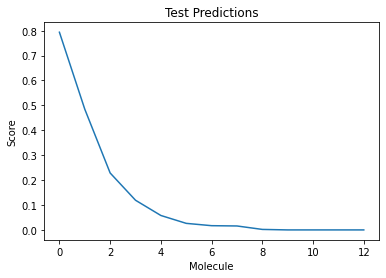

Hits: 1


In [10]:
nums = []

df = pd.read_excel('SupplimentaryTables.xlsx', sheet_name='Sheet2')
nonsmiles = []
for i,j in enumerate(df['SMILES']):
    try:
        x = Chem.MolFromSmiles(j, sanitize=False)
        clean_molecule(x)
        AllChem.GetMorganFingerprintAsBitVect(x,2,useChirality=True,nBits=bits)
    except:
        nonsmiles.append(i)
df.drop(nonsmiles, axis=0, inplace=True)

inp = list(df['SMILES'])
for _ in range(1000):
    model = SGDClassifier(loss='modified_huber', penalty='elasticnet', max_iter=1000, warm_start=True, early_stopping=False, n_jobs=-1)
    model.fit(fingerprint[:,features],label)
    def model_on_list(smiles):
        molecs = [Chem.MolFromSmiles(i, sanitize=False) for i in smiles]
        [clean_molecule(s) for s in molecs]
        fingerprint = np.array([AllChem.GetMorganFingerprintAsBitVect(i,2,useChirality=True,nBits=bits) for i in molecs])[:,features]
        return model.predict_proba(fingerprint)[:,1]
    predictions = model_on_list(inp)
    nums += [predictions]

    print('.',end='')


nums = np.array(nums)
predictions = [nums.mean(axis=0),nums.std(axis=0)/np.sqrt(len(nums)),np.array(df['Name']),np.array(df['SMILES'])]

plt.plot(sorted(predictions[0],reverse=True))
plt.title('Test Predictions')
plt.ylabel('Score')
plt.xlabel('Molecule')
plt.show()

posatives = sorted(list(zip(*[i[predictions[0]>0.5] for i in predictions])),reverse=True)
nhits = len(posatives)
print('Hits:',nhits)
x = pd.DataFrame(posatives)
x.columns=['Score','SE','Name','SMILES']
x.to_excel('SupplimentaryTablesPredict.xlsx',index=False)